# Raster Data Tutorials


This tutorial is designed to show you how to read and work with raster data. We have 4 different goals here:
1. Loading a raster dataset with xarray
1. Subsetting the raster dataset along its coordinate axes
1. Plotting the raster dataset (with xarray and matplotlib)
1. Computing streamlines from a vector field
1. Interpolating values along a line from a raster dataset

So, lets start by importing the necessary modules:

In [3]:
import xarray as xr
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt
import glob
import sys

sys.path.append('/mnt/data01/Code/')
import NDH_Tools as ndh

#### 1 -- Opening the dataset
`xarray` is the primary package for opening and plotting raster data. Built on top of xarray is another package called `rioxarray`, which provides some functionality for doing coordinate reprojection of gridded data. There are several types of common raster datasets that you might be familiar with:
* Typical imagery data (bmp, gif, png, tiff), which typically contain just a multi-dimensional (MxNx3 or MxNx4) raster image storing the intensities of the primary colors of light (red, green, blue) and possibly a transparency value (alpha).
* GeoTIFF -- these files mirror a normal tiff image (a multi-dimensional raster image) but the data are somehow geographic in nature. So perhaps, each pixel represents the height of Earth's surface, or the temperature, or the pressure. In addition to the raster data, GeoTIFFs contain information about the "map project" of the data -- as in, what are the spatial coordinates of each pixel.
* NetCDF files -- these can contain any number of raster datasets, as well as information that describes the coordinate axes (as in, describing what each row and each column of a dataset represent). These are very common for climate data.

`xarray` and `rioxarray` each have their own function for loading a raster dataset, which are:

* `xr.open_dataset()`
* `rxr.open_rasterio()`

`xarray` cannot natively open GeoTIFF format files, but sometimes `rioxarray` messes up NetCDFs when it tries to read them in. As a result, it might behoove you to try using both, if you are finding the data structure of the file, when read in, does not look how you expect it should.

In [4]:
datadir = '/mnt/data01/Data/Antarctic_Velocity/'
fn = glob.glob(datadir+'*.nc')

########## Read in with rioxarray
data_rxr = rxr.open_rasterio(fn[0])
data_rxr

####### Reading with xarray
data = xr.open_dataset(fn[0])

One nice thing about xarray and rioxarray is that they will nicely show you the structure of the data once you have read in a raster dataset. Simply calling the name of your object will give you a lot of information about it, with individual components that can be indexed using the name of the coordinate/variable as the "key", similar to how dictionaries are indexed.

In [5]:
data

<xarray.Dataset>
Dimensions:       (x: 12445, y: 12445)
Coordinates:
  * x             (x) float64 -2.8e+06 -2.8e+06 -2.799e+06 ... 2.799e+06 2.8e+06
  * y             (y) float64 2.8e+06 2.8e+06 2.799e+06 ... -2.799e+06 -2.8e+06
    lat           (y, x) float64 ...
    lon           (y, x) float64 ...
Data variables:
    coord_system  |S1 ...
    VX            (y, x) float32 ...
    VY            (y, x) float32 ...
    STDX          (y, x) float32 ...
    STDY          (y, x) float32 ...
    ERRX          (y, x) float32 ...
    ERRY          (y, x) float32 ...
    CNT           (y, x) int32 ...
    SOURCE        (y, x) int8 ...
Attributes: (12/27)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        v_mix.v8Jul2019.nc
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:            
    ...                        ...
    time_coverage_start:       1995-01-01
    time_coverage_end:         2016-12-31
    project:                   NASA/MEaSUREs
    creator_name:              J. Mouginot
    comment:                    
    license:                   No restrictions on access or use.

#### 2 - Subsetting by the coordinate axes

You can see, from the xarray output above, that this dataset has two different dimensions (x and y) which describe variation of each of the provided variables. You can access just the values that describe these dimensions using `data['x']` or `data['y']`. To downselect the data to a specific range of xs and ys, we can use a method that exists on xarray datasets called `.sel`

In [15]:
xs = [-1.6*10**6,0]
ys = [-1.6*10**6,0]

subset_slices = {'x':slice(xs[0],xs[1]),'y':slice(ys[1],ys[0])}

data_sub = data.sel(subset_slices)
data_sub

<xarray.Dataset>
Dimensions:       (x: 3556, y: 3555)
Coordinates:
  * x             (x) float64 -1.6e+06 -1.599e+06 -1.599e+06 ... -550.0 -100.0
  * y             (y) float64 -350.0 -800.0 -1.25e+03 ... -1.599e+06 -1.6e+06
    lat           (y, x) float64 ...
    lon           (y, x) float64 ...
Data variables:
    coord_system  |S1 b''
    VX            (y, x) float32 ...
    VY            (y, x) float32 ...
    STDX          (y, x) float32 ...
    STDY          (y, x) float32 ...
    ERRX          (y, x) float32 ...
    ERRY          (y, x) float32 ...
    CNT           (y, x) int32 ...
    SOURCE        (y, x) int8 ...
Attributes: (12/27)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        v_mix.v8Jul2019.nc
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:            
    ...                        ...
    time_coverage_start:       1995-01-01
    time_coverage_end:         2016-12-31
    project:                   NASA/MEaSUREs
    creator_name:              J. Mouginot
    comment:                    
    license:                   No restrictions on access or use.

#### 3 - Plotting the dataset

There are lots of different ways to plot raster data. Common types of plots are:
* An image (for scalar data - `imshow`)
* A contour plot (for scalar data - `contour` or `contourf`)
* A quiver plot (for vector data - `quiver`)
* A streamplot (for vector data - `streamplot`)

Below, we will calculate the speed from the velocity fields, and generate a few plots as examples of the above. We will use the plot methods from xarray, and also using matplotlib

In [24]:
speed = np.sqrt(data_sub['VX'].values**2 + data_sub['VY'].values**2)
data_sub['speed'] = (('y','x'),speed)

data_sub

<xarray.Dataset>
Dimensions:       (x: 3556, y: 3555)
Coordinates:
  * x             (x) float64 -1.6e+06 -1.599e+06 -1.599e+06 ... -550.0 -100.0
  * y             (y) float64 -350.0 -800.0 -1.25e+03 ... -1.599e+06 -1.6e+06
    lat           (y, x) float64 ...
    lon           (y, x) float64 ...
Data variables:
    coord_system  |S1 b''
    VX            (y, x) float32 1.002 0.3267 0.03414 -0.05143 ... nan nan nan
    VY            (y, x) float32 -37.75 -37.11 -36.72 -36.36 ... nan nan nan nan
    STDX          (y, x) float32 ...
    STDY          (y, x) float32 ...
    ERRX          (y, x) float32 ...
    ERRY          (y, x) float32 ...
    CNT           (y, x) int32 ...
    SOURCE        (y, x) int8 ...
    speed         (y, x) float32 37.76 37.11 36.72 36.36 ... nan nan nan nan
Attributes: (12/27)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        v_mix.v8Jul2019.nc
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:            
    ...                        ...
    time_coverage_start:       1995-01-01
    time_coverage_end:         2016-12-31
    project:                   NASA/MEaSUREs
    creator_name:              J. Mouginot
    comment:                    
    license:                   No restrictions on access or use.

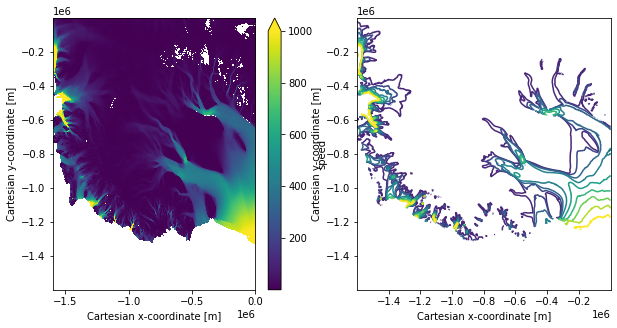

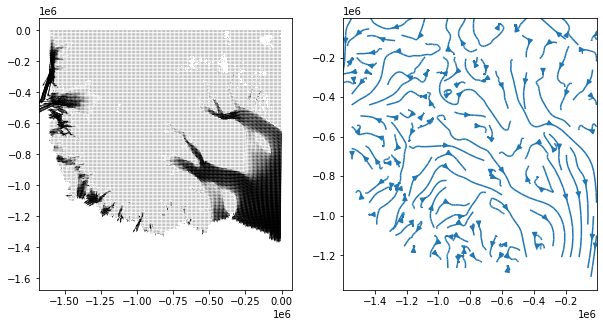

In [39]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
data_sub['speed'].plot.imshow(vmax=1000)

plt.subplot(1,2,2)
data_sub['speed'].plot.contour(levels=np.arange(0,1000,100))

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.quiver(data_sub['x'].values[::20],np.flipud(data_sub['y'].values[::20]),np.flipud(data_sub['VX'].values[::20,::20]),np.flipud(data_sub['VY'].values[::20,::20]))

plt.subplot(1,2,2)
plt.streamplot(data_sub['x'].values[::20],np.flipud(data_sub['y'].values[::20]),np.flipud(data_sub['VX'].values[::20,::20]),np.flipud(data_sub['VY'].values[::20,::20]))

#### 4 -- Generating a flowline through a region of interest

Here we generate a specific streamline based on a seed point in a vector field.

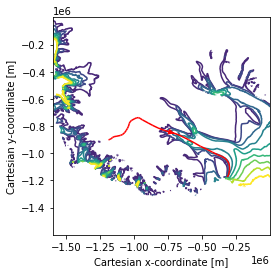

In [58]:
startpoints = np.array([[-0.6*10**6,-1.35*10**6], [-0.9*10**6,-0.45*10**6]])

data_sub['speed'].plot.contour(levels=np.arange(0,1000,100))
streamlines = plt.streamplot(data_sub['x'].values,np.flipud(data_sub['y'].values),np.flipud(data_sub['VX'].values),np.flipud(data_sub['VY'].values), 
                             start_points=[startpoints.T[0,:]],color='red')

########### Here we extract the coordinate information along the streamline
sl = [streamlines.lines.get_paths()[0].vertices[0]]
for i in streamlines.lines.get_paths():
    sl.append(i.vertices[1])

sl = np.array(sl)

plt.gca().set_aspect('equal')

#### 5 -- Interpolate and extract the values along those points

The confusing part here is constructing the right objects to use to index the xarray object. We need to construct two objects -- one that contains all the x coordinates for the points we want to extract, and one that contains all of the y coordinates for the points we want to extract. Critically, these objects must have some new "dimension". I use here a dimension called the "vector_index", but this can be anything -- this is just a constructed "axis" along which we are describing variations in the observations.

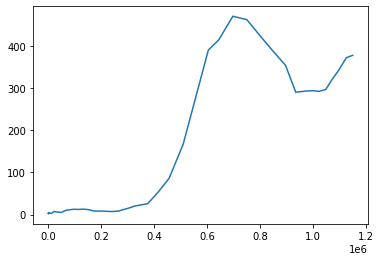

In [83]:
x_search = xr.DataArray(sl[:,0],dims=['vector_index'])
y_search = xr.DataArray(sl[:,1],dims=['vector_index'])
extracted_values = data_sub['speed'].interp(x=x_search,y=y_search)

dists = ndh.distance_vector(sl[:,0],sl[:,1])

plt.plot(dists,extracted_values.values)